#### Import libraries

In [1]:
import numpy as np
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
from collections import Counter
import time
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

#### Declare parameters

In [2]:
# declare path
train_dir = 'fer/train'
test_dir = 'fer/test'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BS = 100
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

#### Load data

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    #zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
# Load dataset

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS,
                                                   shuffle = True)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =False,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### Data Exploration
It can be found in this <a href='https://github.com/Oldmajor19/Face-emotion-detection/blob/main/model_training.ipynb'>notebook</a>

#### Modeling
I would be making use of VGG16 for this work

In [5]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [7]:
# Freezing Layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
# Building model
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [9]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [10]:
# create metrics
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.legacy.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [12]:
#starting time
start = time.time()

# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

# end time
end = time.time()

# total time taken
print("Execution time of the program is- ", end - start)

Epoch 1/100
288/288 [==============================] - 276s 953ms/step - loss: 5.3353 - accuracy: 0.8152 - precision: 0.1995 - recall: 0.0976 - auc: 0.5468 - f1_score: 0.1311 - val_loss: 2.3975 - val_accuracy: 0.8486 - val_precision: 0.3964 - val_recall: 0.1144 - val_auc: 0.6937 - val_f1_score: 0.1703 - lr: 1.0000e-04
Epoch 2/100
288/288 [==============================] - 294s 1s/step - loss: 4.8326 - accuracy: 0.8249 - precision: 0.2539 - recall: 0.1164 - auc: 0.5885 - f1_score: 0.1589 - val_loss: 2.4530 - val_accuracy: 0.8528 - val_precision: 0.4532 - val_recall: 0.1463 - val_auc: 0.6847 - val_f1_score: 0.2113 - lr: 1.0000e-04
Epoch 3/100
288/288 [==============================] - 306s 1s/step - loss: 4.5787 - accuracy: 0.8303 - precision: 0.2780 - recall: 0.1177 - auc: 0.6060 - f1_score: 0.1650 - val_loss: 3.0792 - val_accuracy: 0.8225 - val_precision: 0.3135 - val_recall: 0.2041 - val_auc: 0.6514 - val_f1_score: 0.2322 - lr: 1.0000e-04
Epoch 4/100
288/288 [=========================

Epoch 27/100
288/288 [==============================] - 245s 849ms/step - loss: 2.7962 - accuracy: 0.8691 - precision: 0.6494 - recall: 0.1813 - auc: 0.7893 - f1_score: 0.2826 - val_loss: 1.6620 - val_accuracy: 0.8741 - val_precision: 0.6554 - val_recall: 0.2503 - val_auc: 0.8122 - val_f1_score: 0.3207 - lr: 1.0000e-04
Epoch 28/100
288/288 [==============================] - 239s 831ms/step - loss: 2.7743 - accuracy: 0.8687 - precision: 0.6369 - recall: 0.1885 - auc: 0.7912 - f1_score: 0.2911 - val_loss: 1.5869 - val_accuracy: 0.8776 - val_precision: 0.6735 - val_recall: 0.2782 - val_auc: 0.8319 - val_f1_score: 0.3459 - lr: 1.0000e-04
Epoch 29/100
288/288 [==============================] - 240s 833ms/step - loss: 2.7559 - accuracy: 0.8696 - precision: 0.6473 - recall: 0.1919 - auc: 0.7934 - f1_score: 0.2945 - val_loss: 1.7743 - val_accuracy: 0.8659 - val_precision: 0.5983 - val_recall: 0.1865 - val_auc: 0.7775 - val_f1_score: 0.2614 - lr: 1.0000e-04
Epoch 30/100
288/288 [===============

Epoch 53/100
288/288 [==============================] - 234s 814ms/step - loss: 2.3248 - accuracy: 0.8799 - precision: 0.6941 - recall: 0.2849 - auc: 0.8449 - f1_score: 0.4035 - val_loss: 1.4158 - val_accuracy: 0.8826 - val_precision: 0.6869 - val_recall: 0.3274 - val_auc: 0.8542 - val_f1_score: 0.4155 - lr: 1.0000e-04
Epoch 54/100
288/288 [==============================] - 234s 813ms/step - loss: 2.3100 - accuracy: 0.8806 - precision: 0.6979 - recall: 0.2891 - auc: 0.8465 - f1_score: 0.4079 - val_loss: 1.4831 - val_accuracy: 0.8763 - val_precision: 0.6469 - val_recall: 0.2960 - val_auc: 0.8387 - val_f1_score: 0.3901 - lr: 1.0000e-04
Epoch 55/100
288/288 [==============================] - 235s 815ms/step - loss: 2.2877 - accuracy: 0.8803 - precision: 0.6946 - recall: 0.2892 - auc: 0.8483 - f1_score: 0.4078 - val_loss: 1.3868 - val_accuracy: 0.8844 - val_precision: 0.6895 - val_recall: 0.3468 - val_auc: 0.8608 - val_f1_score: 0.4382 - lr: 1.0000e-04
Epoch 56/100
288/288 [===============

288/288 [==============================] - 232s 806ms/step - loss: 2.0346 - accuracy: 0.8887 - precision: 0.7184 - recall: 0.3636 - auc: 0.8744 - f1_score: 0.4821 - val_loss: 1.3483 - val_accuracy: 0.8849 - val_precision: 0.6651 - val_recall: 0.3912 - val_auc: 0.8645 - val_f1_score: 0.4716 - lr: 1.0000e-04
Epoch 79/100
288/288 [==============================] - 273s 949ms/step - loss: 2.0056 - accuracy: 0.8894 - precision: 0.7218 - recall: 0.3679 - auc: 0.8775 - f1_score: 0.4857 - val_loss: 1.3542 - val_accuracy: 0.8843 - val_precision: 0.6734 - val_recall: 0.3696 - val_auc: 0.8626 - val_f1_score: 0.4584 - lr: 1.0000e-04
Epoch 80/100
288/288 [==============================] - 321s 1s/step - loss: 2.0362 - accuracy: 0.8886 - precision: 0.7162 - recall: 0.3651 - auc: 0.8751 - f1_score: 0.4839 - val_loss: 1.3260 - val_accuracy: 0.8853 - val_precision: 0.6763 - val_recall: 0.3781 - val_auc: 0.8678 - val_f1_score: 0.4696 - lr: 1.0000e-04
Epoch 81/100
288/288 [==============================]

#### Evaluate model

In [13]:
#Scores of train & test set
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

72/72 [==============================] - 15s 210ms/step - loss: 1.2950 - accuracy: 0.8877 - precision: 0.6603 - recall: 0.4401 - auc: 0.8769 - f1_score: 0.5197


In [15]:
from IPython.display import Image, HTML
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,1.044,1.295
1,Accuracy,0.906,0.888
2,Precision,0.773,0.660
3,Recall,0.486,0.440
4,Auc,0.919,0.877
5,F1_Score,0.597,0.520


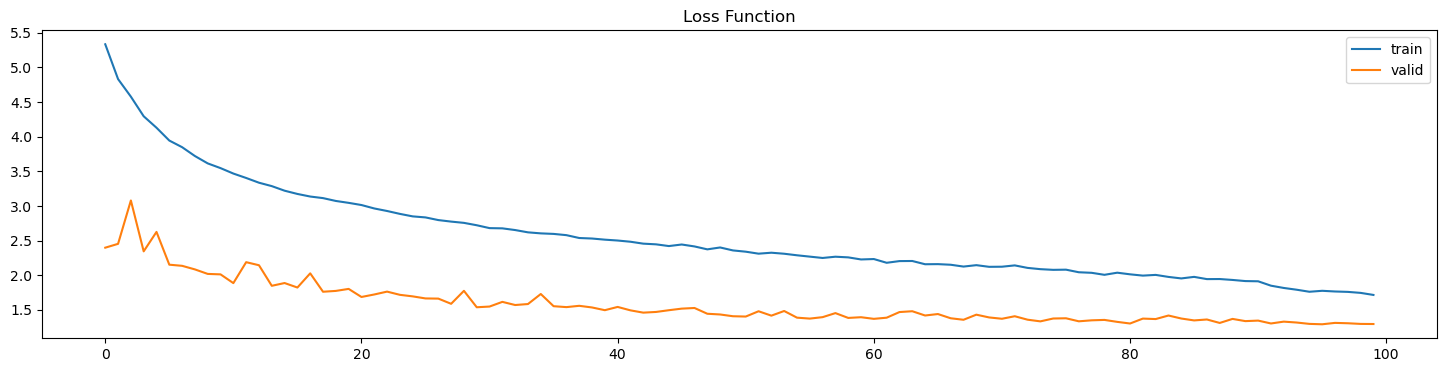

In [17]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

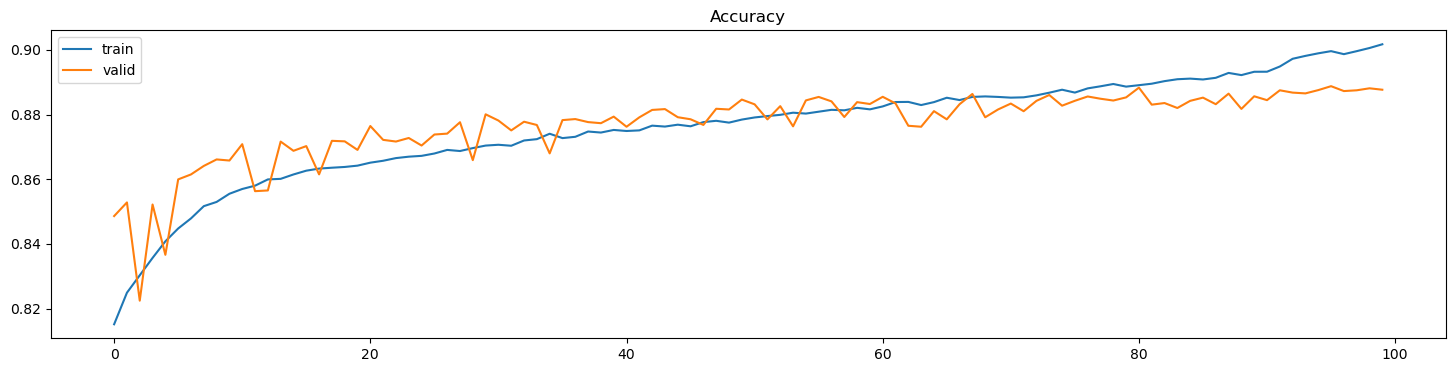

In [18]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

72/72 [==============================] - 16s 220ms/step
Confusion matrix, without normalization

[[ 481   25   87   59  118  161   27]
 [  11   76    3    7    2    9    3]
 [ 161   13  326   52  116  225  131]
 [ 108   12   68 1245  150  143   48]
 [ 113    8   80  110  648  244   30]
 [ 170   16  118  105  235  563   40]
 [  48    0   67   22   55   26  613]]





C:\Users\joshu\AppData\Local\Temp\ipykernel_23720\130565507.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


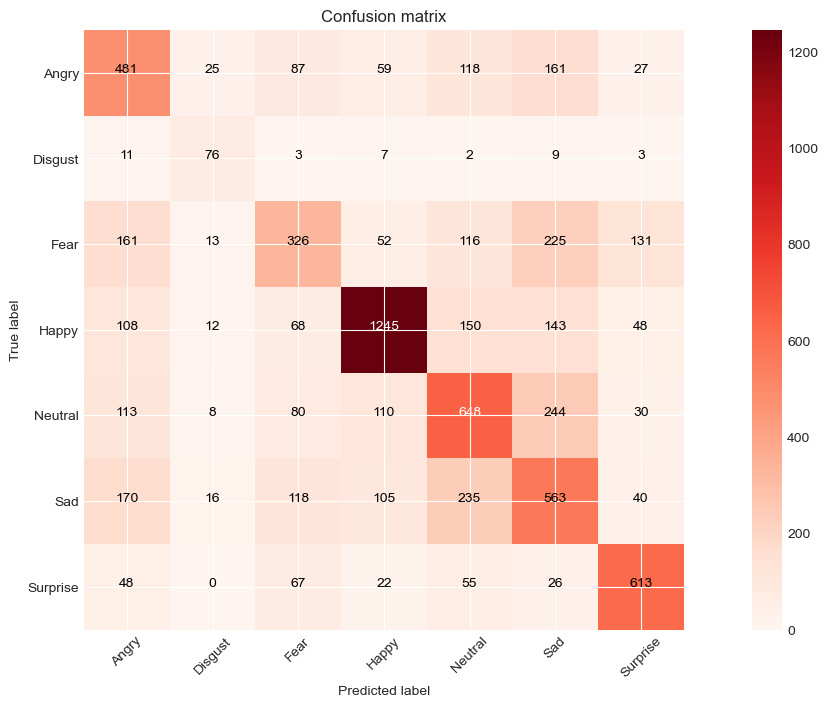

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
#Plot confusion matrix
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
# Save model
model.save("Emotion.h5")